In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

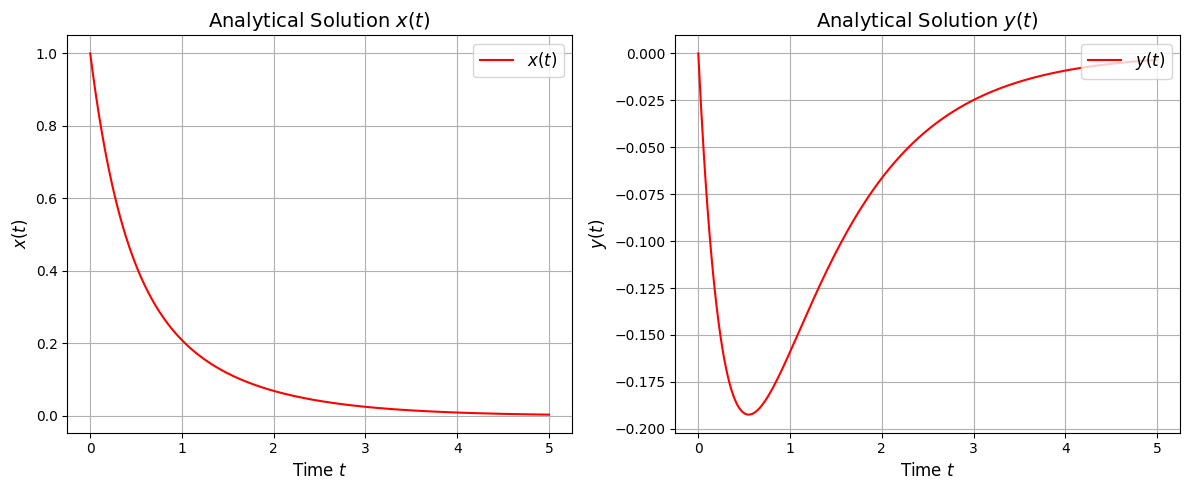

In [2]:
#Visualizing the Analytical Solutions
t = np.linspace(0,5,500)

# Define the analytical solutions for x(t) and y(t)
x_analytical = 0.5 * np.exp(-t) + 0.5 * np.exp(-3 * t)
y_analytical = -0.5 * np.exp(-t) + 0.5 * np.exp(-3 * t)

# Set up the plot with two subplots side by side
plt.figure( figsize = (12,5))

# Plot x(t)
plt.subplot(1, 2, 1)
plt.plot(t, x_analytical, label =r'$x(t)$', color = 'red')
plt.title(r'Analytical Solution $x(t)$', fontsize = 14)
plt.xlabel(r'Time $t$', fontsize = 12)
plt.ylabel(r'$x(t)$', fontsize = 12)
plt.grid(True)
plt.legend(fontsize = 12, loc = 'upper right')

# Plot y(t)
plt.subplot(1, 2, 2)
plt.plot(t, y_analytical, label=r'$y(t)$', color = 'red')
plt.title(r'Analytical Solution $y(t)$', fontsize = 14)
plt.xlabel(r'Time $t$', fontsize = 12)
plt.ylabel(r'$y(t)$', fontsize = 12)
plt.grid(True)
plt.legend(fontsize=12, loc='upper right')

#Adjust layout and plot display
plt.tight_layout()
plt.show()


In [3]:
#Define the neural network model
class PINN(tf.keras.Model):
  def __init__(self):
    super(PINN, self).__init__()
    self.dense1= tf.keras.layers.Dense(50, activation='tanh')
    self.dense2= tf.keras.layers.Dense(50, activation='tanh')
    self.dense3= tf.keras.layers.Dense(2, activation=None)


  #call_model() - Function to define the forward pass of nn
  #Takes as an input a dictionary model and an input tensor x

  def call(self,t):
    t = self.dense1(t)
    t = self.dense2(t)

    return self.dense3(t)

  #model = create_model()
  #print(model)

In [4]:
#Define the loss function
def loss_fn(model,t):
    with tf.GradientTape(persistent=True) as tape1, tf.GradientTape(persistent=True) as tape2:
      tape1.watch(t)
      tape2.watch(t)
      output = model(t)
      x = output[:, 0:1]
      y = output[:, 1:2]

      dx_dt = tape1.gradient(x,t)
      dy_dt = tape2.gradient(y,t)

      #Residuals from the ODEs
      res_x = dx_dt + 2*x + y
      res_y = dy_dt + x + 2*y

      # Initial condition losses
      init_loss_x = tf.square(x[0] - 1)
      init_loss_y = tf.square(y[0] - 0)

      # Total Loss
      loss = tf.reduce_mean(tf.square(res_x)) + tf.reduce_mean(tf.square(res_y)) + init_loss_x + init_loss_y

    return loss



In [5]:
# Define the training step
def train(model, t, epochs, optimizer):
  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      loss = loss_fn(model, t)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 500 == 0:
      print(f'Epoch {epoch}; Loss = {loss.numpy()}')

In [6]:
# Create the model and optimizer
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training domain
t = tf.convert_to_tensor(np.linspace(0, 5, 100)[:, None], dtype = tf.float32)

# Train the model
train(model, t, epochs = 4000, optimizer = optimizer)

Epoch 0; Loss = [1.0466971]
Epoch 500; Loss = [0.0010861]
Epoch 1000; Loss = [0.00027481]
Epoch 1500; Loss = [0.00016532]
Epoch 2000; Loss = [0.00011914]
Epoch 2500; Loss = [8.2920254e-05]
Epoch 3000; Loss = [5.593378e-05]
Epoch 3500; Loss = [3.567758e-05]


In [7]:
#Prediction using the trained model
t_test = np.linspace(0, 5, 100)[:, None]
x_pred, y_pred = model(t_test).numpy().T

In [8]:
# Analytical solutions

x_true = 0.5 * np.exp(-t_test) + 0.5 * np.exp(-3 * t_test)
y_true = -0.5 * np.exp(-t_test) + 0.5 * np.exp(-3 * t_test)

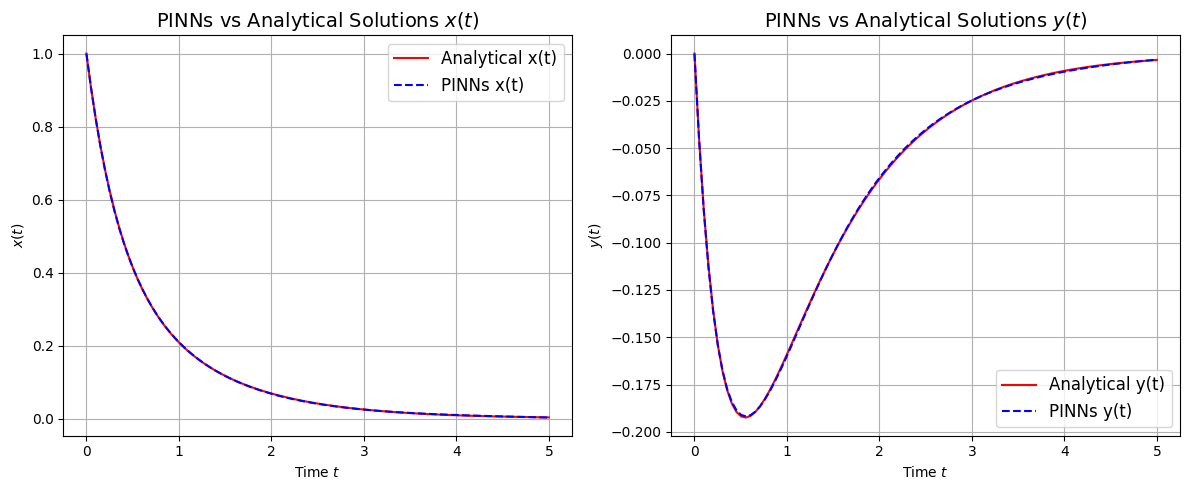

In [9]:
# Comparing the results

plt.figure(figsize = (12,5))

# Plot x(t)
plt.subplot(1, 2, 1)
plt.plot(t_test, x_true, label='Analytical x(t)', color='red')
plt.plot(t_test, x_pred, '--', label = 'PINNs x(t)', color = 'blue')
plt.title(r'PINNs vs Analytical Solutions $x(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc='upper right')

# Plot y(t)
plt.subplot(1, 2, 2)
plt.plot(t_test, y_true, label='Analytical y(t)', color='red')
plt.plot(t_test, y_pred, '--', label = 'PINNs y(t)', color = 'blue')
plt.title(r'PINNs vs Analytical Solutions $y(t)$', fontsize=14)
plt.xlabel(r'Time $t$')
plt.ylabel(r'$y(t)$')
plt.grid(True)
plt.legend(fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()